In [33]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt


In [15]:
data = pd.read_csv("malicious_phish.csv") 
data['type'] = data['type'].astype(str)

In [16]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(data['url'])
y = data['type']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [19]:
y_pred_lr = lr_model.predict(X_test)
print("Logistic Regression Results:\n", classification_report(y_test, y_pred_lr))


Logistic Regression Results:
               precision    recall  f1-score   support

      benign       0.94      0.99      0.96     85778
  defacement       0.99      0.99      0.99     19104
     malware       0.99      0.95      0.97      6521
    phishing       0.92      0.73      0.81     18836

    accuracy                           0.95    130239
   macro avg       0.96      0.91      0.93    130239
weighted avg       0.95      0.95      0.95    130239



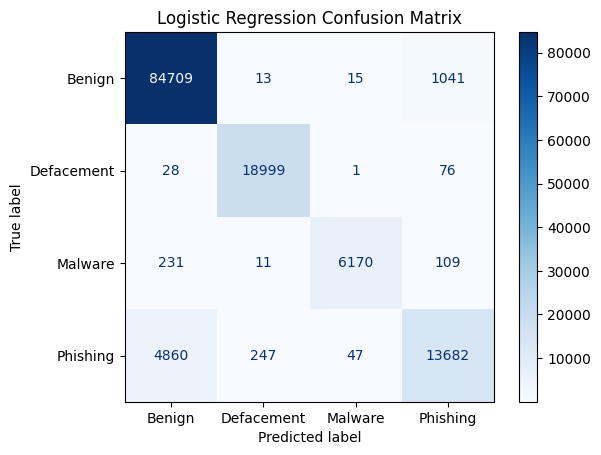

In [20]:
cm = confusion_matrix(y_test, y_pred_lr)
class_names = ['Benign', 'Defacement', 'Malware', 'Phishing']  # Replace with actual class names

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Logistic Regression Confusion Matrix")
plt.show()

In [22]:
urls = data['url'].astype(str).values

In [25]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(urls)

In [26]:
max_vocab_size = len(tokenizer.word_index) + 1
max_vocab_size

549209

In [27]:
url_lengths = [len(tokenizer.texts_to_sequences([url])[0]) for url in urls]

In [30]:
max_length = int(np.percentile(url_lengths, 95))
max_length

21

In [34]:
labels = data['type'].values  
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

In [35]:
tokenizer = Tokenizer(num_words=max_vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(urls)
sequences = tokenizer.texts_to_sequences(urls)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

In [36]:
X_train, X_test, y_train, y_test = train_test_split(
    padded_sequences, labels_encoded, test_size=0.2, random_state=42
)

In [37]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes=4)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=4)

In [38]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_vocab_size, 128, input_length=max_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')  # 4 output units for 4 classes
])

/Users/jawayria/PycharmProjects/MaliciousURLClassification/.venv/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [39]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [40]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)

In [41]:
model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_split=0.1,
    callbacks=[early_stopping, checkpoint],
    verbose=1
)

Epoch 1/10
7326/7326 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.9352 - loss: 0.1787
Epoch 1: val_loss improved from inf to 0.08572, saving model to best_model.keras
7326/7326 ━━━━━━━━━━━━━━━━━━━━ 1204s 164ms/step - accuracy: 0.9352 - loss: 0.1787 - val_accuracy: 0.9688 - val_loss: 0.0857
Epoch 2/10
7326/7326 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.9950 - loss: 0.0155
Epoch 2: val_loss did not improve from 0.08572
7326/7326 ━━━━━━━━━━━━━━━━━━━━ 1236s 169ms/step - accuracy: 0.9950 - loss: 0.0155 - val_accuracy: 0.9553 - val_loss: 0.1167
Epoch 3/10
7326/7326 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.9988 - loss: 0.0038
Epoch 3: val_loss did not improve from 0.08572
7326/7326 ━━━━━━━━━━━━━━━━━━━━ 1172s 160ms/step - accuracy: 0.9988 - loss: 0.0038 - val_accuracy: 0.9361 - val_loss: 0.2032
Epoch 4/10
7326/7326 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.9992 - loss: 0.0022
Epoch 4: val_loss did not improve from 0.08572
7326/7326 ━━━━━━━━━━━━━━━━━━━━ 1162s 159ms/ste

In [42]:
model.load_weights('best_model.keras')

y_pred = np.argmax(model.predict(X_test), axis=1)
y_test_labels = np.argmax(y_test, axis=1)
print("Accuracy:", accuracy_score(y_test_labels, y_pred))
print("Classification Report:\n", classification_report(y_test_labels, y_pred, target_names=label_encoder.classes_))

4070/4070 ━━━━━━━━━━━━━━━━━━━━ 1s 328us/step
Accuracy: 0.9677746297192086
Classification Report:
               precision    recall  f1-score   support

      benign       0.96      0.99      0.98     85778
  defacement       1.00      1.00      1.00     19104
     malware       0.99      0.96      0.98      6521
    phishing       0.95      0.83      0.89     18836

    accuracy                           0.97    130239
   macro avg       0.97      0.95      0.96    130239
weighted avg       0.97      0.97      0.97    130239



4070/4070 ━━━━━━━━━━━━━━━━━━━━ 1s 334us/step
Accuracy: 0.9677746297192086
Classification Report:
               precision    recall  f1-score   support

      benign       0.96      0.99      0.98     85778
  defacement       1.00      1.00      1.00     19104
     malware       0.99      0.96      0.98      6521
    phishing       0.95      0.83      0.89     18836

    accuracy                           0.97    130239
   macro avg       0.97      0.95      0.96    130239
weighted avg       0.97      0.97      0.97    130239



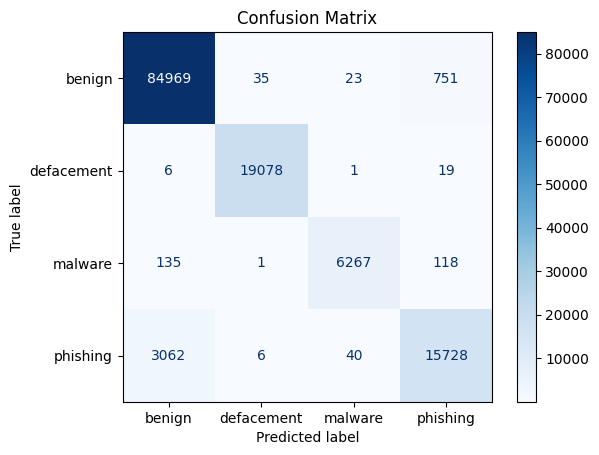

In [46]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Evaluate the model
y_pred = np.argmax(model.predict(X_test), axis=1)
y_test_labels = np.argmax(y_test, axis=1)

# Calculate accuracy and classification report
print("Accuracy:", accuracy_score(y_test_labels, y_pred))
print("Classification Report:\n", classification_report(y_test_labels, y_pred, target_names=label_encoder.classes_))

# Generate confusion matrix
cm = confusion_matrix(y_test_labels, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

